In [1]:
# Necessário pois a versão atual é incompatível com o mostrado no curso
#!pip install tensorflow==2.8.0
#!pip install protobuf==3.20.3

In [2]:
# Importações necessárias
import cv2
import numpy as np
import pandas as pd
from google.colab.patches import cv2_imshow
import zipfile
import tensorflow
from tensorflow.python.keras.models import load_model
from keras.preprocessing.image import img_to_array
from keras.layers import BatchNormalization
%tensorflow_version 2.8.0
tensorflow.__version__

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


'2.8.0'

In [3]:
# Conexão com o google drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
'''path = "/content/gdrive/MyDrive/materiasi/Material.zip" # Armazenamento do caminho dos arquivos
zip_obj = zipfile.ZipFile(file = path, mode = "r") # Acesso do arquivo no modo de leitura
zip_obj.extractall("/content/gdrive/MyDrive/materiasi") # Extração dos arquivos zipados
zip_obj.close # Liberação de memória'''

'path = "/content/gdrive/MyDrive/materiasi/Material.zip" # Armazenamento do caminho dos arquivos\nzip_obj = zipfile.ZipFile(file = path, mode = "r") # Acesso do arquivo no modo de leitura\nzip_obj.extractall("/content/gdrive/MyDrive/materiasi") # Extração dos arquivos zipados\nzip_obj.close # Liberação de memória'

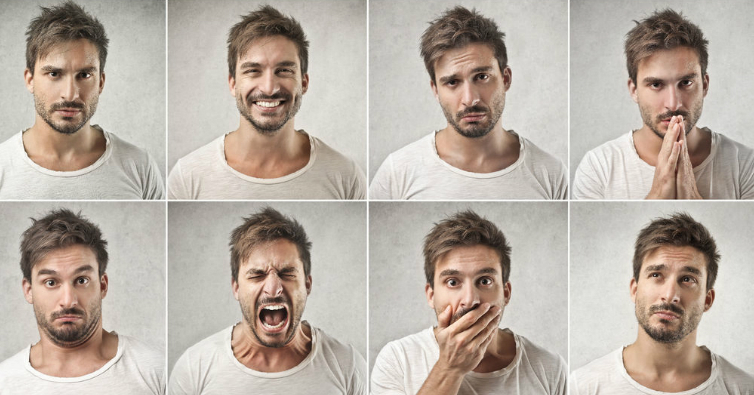

In [5]:
imagens = [] # Vetor para armazenar as imagens
for i in range(6): # For que percorre as imagens
  img = cv2.imread(f"/content/gdrive/MyDrive/materiasi/Material/testes/teste0{i+1}.jpg")
  if img is None: # Verifica se o caminho foi correto, se não ele corrige
      imagens.append(cv2.imread(f"/content/gdrive/MyDrive/materiasi/Material/testes/teste0{i+1}.png"))
  else:
    imagens.append(img)
cv2_imshow(imagens[1]) # Teste para ver se está sendo armazenado corretametne

In [6]:
cascade_faces = "/content/gdrive/MyDrive/materiasi/Material/haarcascade_frontalface_default.xml" # Base de dados
caminho_modelo = "/content/gdrive/MyDrive/materiasi/Material/modelo_01_expressoes.h5" # Modelo de treinamento
face_detection = cv2.CascadeClassifier(cascade_faces) # Objeto para detecção de faces
expressoes = ["Raiva", "Nojo","Medo", "Feliz", "Triste","Surpreso", "Neutro"] # Classes
classificador_emocoes = load_model(caminho_modelo, compile=False, custom_objects = {'BatchNormalization': BatchNormalization}) # Classificador

In [7]:
faces = []
for i in range(6): # For que percorre as imagens
  original = imagens[i].copy() # Cópia da imagem
  faces.append(face_detection.detectMultiScale(original,scaleFactor=1.1,minNeighbors=3 ,minSize=(20, 20))) # Armazenamento das faces
faces[2]

array([[  57,   30,  119,  119],
       [ 760,   31,  126,  126],
       [ 287,   21,  138,  138],
       [ 978,   30,  145,  145],
       [ 304,  252,  112,  112],
       [ 757,  256,  125,  125],
       [ 991,  264,  109,  109],
       [  53,  271,  138,  138],
       [ 499,  257,  179,  179],
       [ 993,  493,  122,  122],
       [ 284,  490,  142,  142],
       [ 522,  503,  141,  141],
       [ 300,  733,  107,  107],
       [  72,  739,  105,  105],
       [ 524,  732,  132,  132],
       [ 770,  744,  114,  114],
       [ 994,  738,  123,  123],
       [ 301,  958,  111,  111],
       [ 523,  943,  134,  134],
       [  51,  957,  145,  145],
       [ 988,  969,  140,  140],
       [ 996, 1024,  121,  121],
       [ 769,  985,  102,  102]], dtype=int32)

In [8]:
roi = []
for i in range(6): # For que percorre as imagens
  for (x, y, w, h) in faces[i]:
        img = imagens[i] # Salva a imagem atual
        roi.append(img[y:y+h, x:x+w]) # Salva as faces cortadas
len(roi) # Número de faces

56

In [9]:
for i in range(len(roi)):
  roi[i] = cv2.cvtColor(roi[i], cv2.COLOR_BGR2GRAY) # Converte para escala de cinza
  roi[i] = cv2.resize(roi[i], (48, 48)) # Diminui o tamanho para melhorar a performance do treinamento
  roi[i] = roi[i].astype('float')  # Converte os valores para float
  roi[i] = roi[i] / 255 # Deixa entre 0 e 1
  roi[i] = img_to_array(roi[i]) # Converte para array
  roi[i] = np.expand_dims(roi[i], axis=0) # Adiciona uma nova dimensão para ficar compativel com o tensorflow
roi[1].shape

(1, 48, 48, 1)

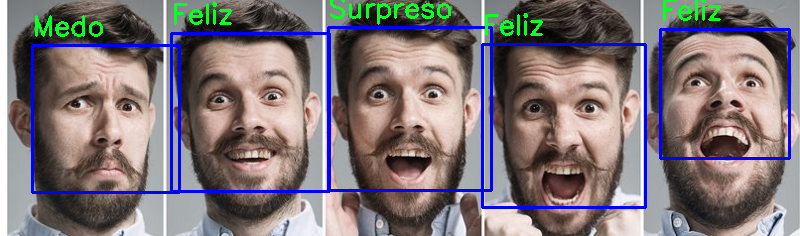

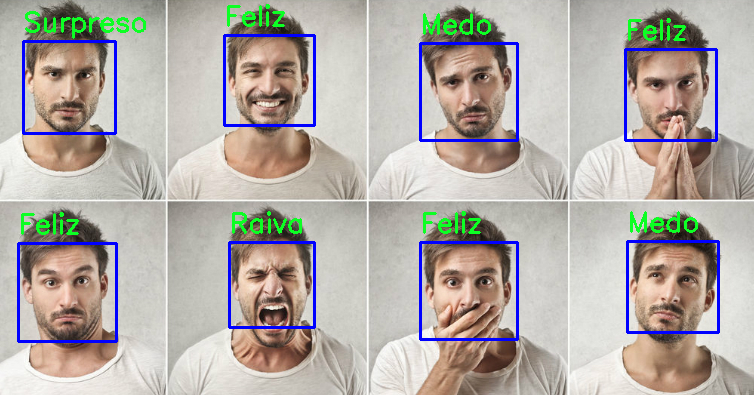

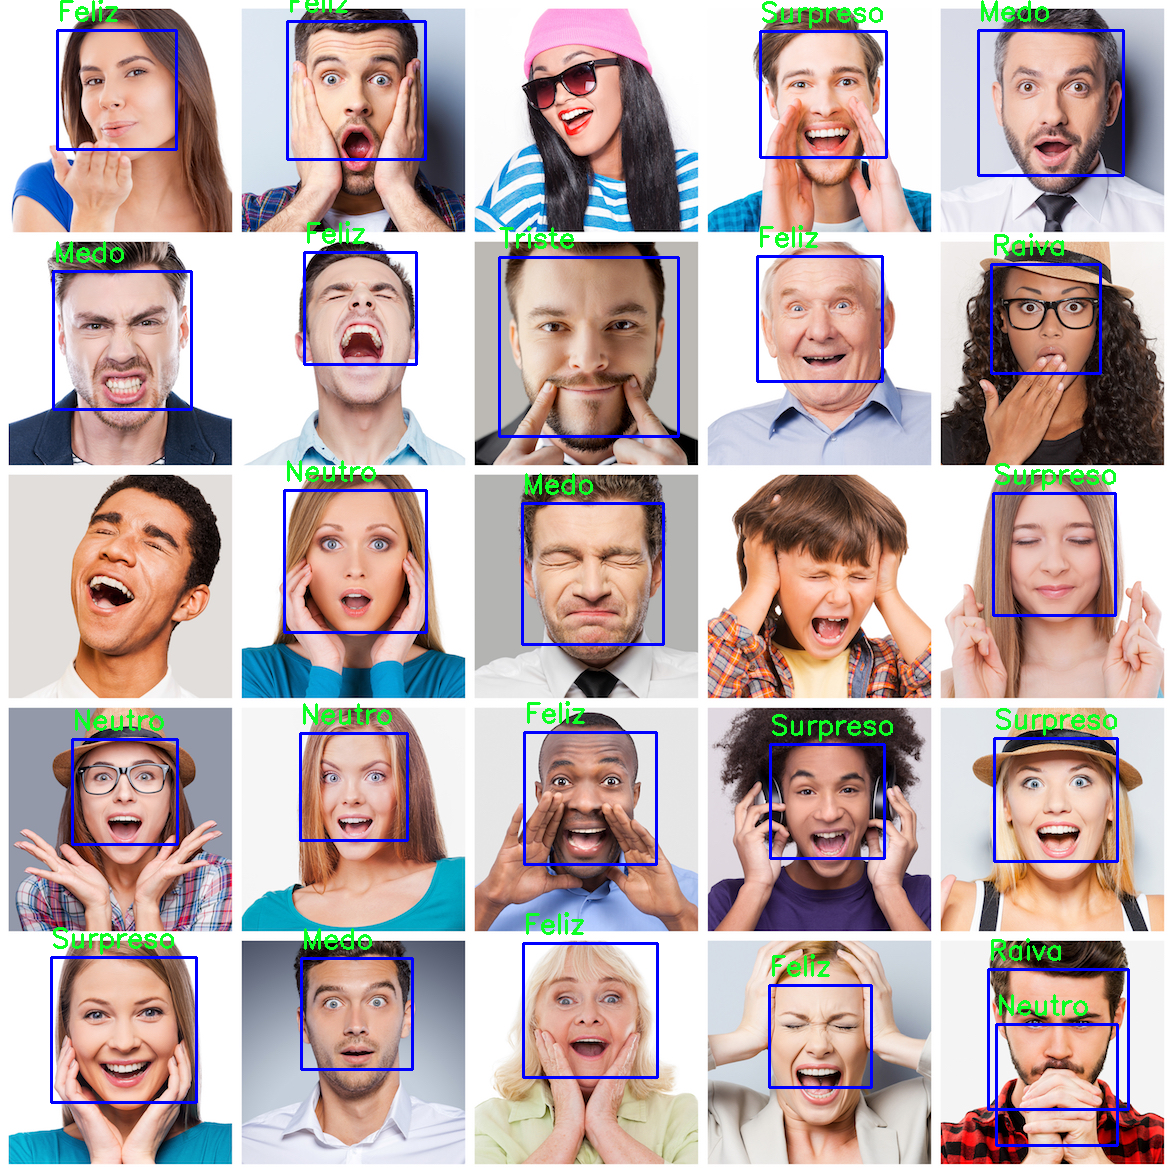

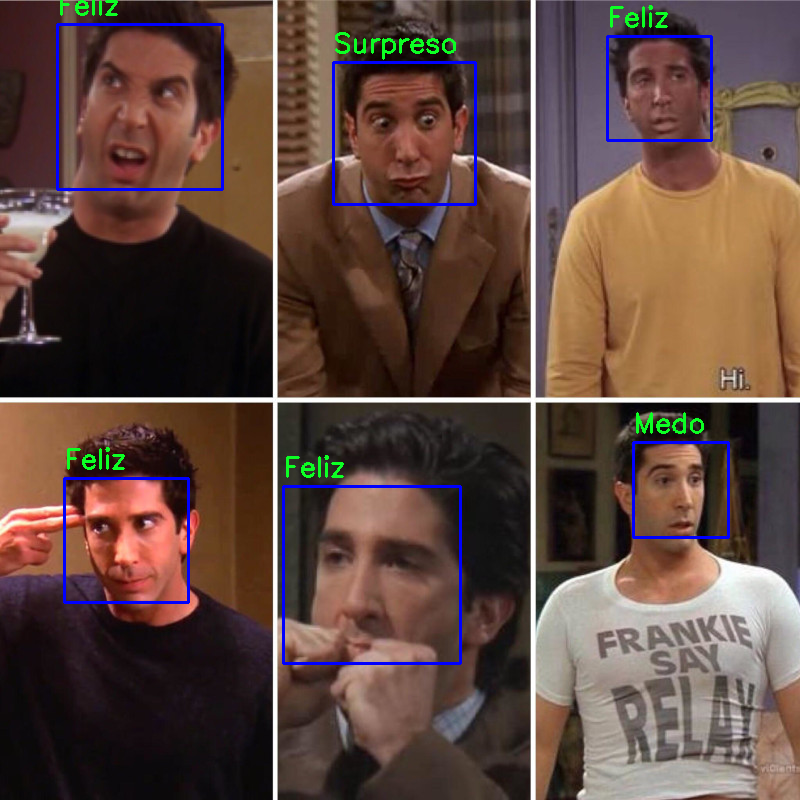

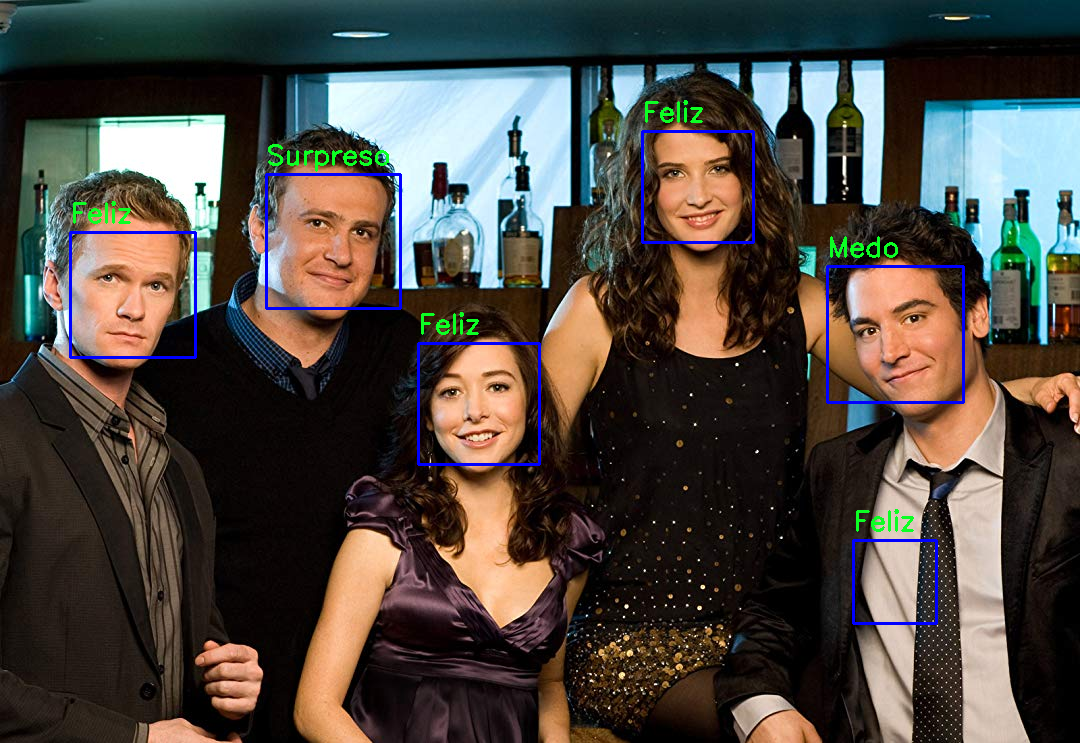

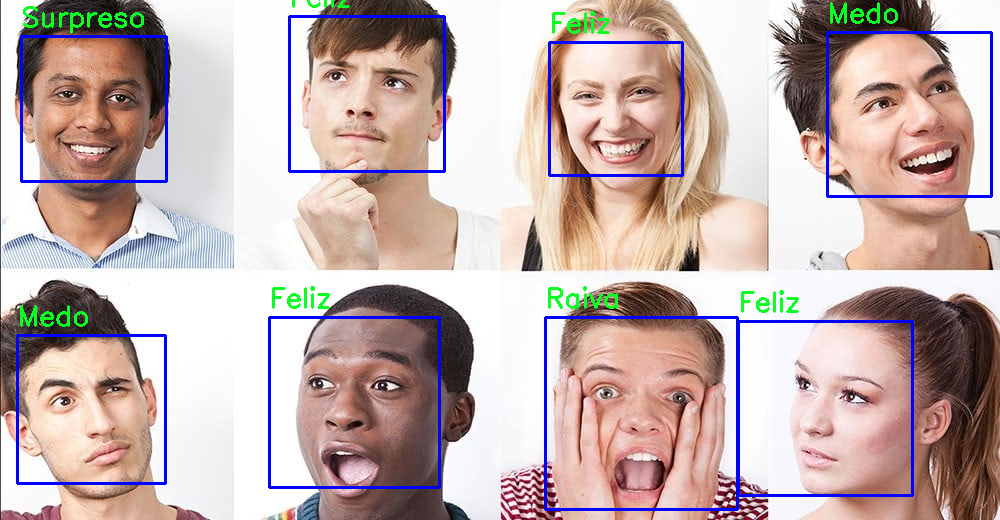

In [42]:
for i in range(len(imagens)): # Percorre as imagens
    for j in range(len(faces[i])): # Percorre as faces
        preds = classificador_emocoes.predict(roi[j])[0] # Predicao da face atual
        label = expressoes[preds.argmax()] # Label da face atual
        x, y, w, h = faces[i][j] # Posição da face
        for k in range(len(faces)): # Adiciona todas as labels e quadrados de cada face
          cv2.rectangle(imagens[i], (x, y), (x + w, y + h), (255, 0, 0), 2) # Quadrado da face
          cv2.putText(imagens[i], label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36, 255, 12), 2) # Label
    cv2_imshow(imagens[i]) # Mostra a imagem